# Brain MRI Segmentation using UNet

### Importing Libraries

In [2]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
import pandas as pd
from tqdm import tqdm
from unet import build_unet


### Global parameters

In [22]:
H = 256
W = 256
images = sorted(glob(os.path.join("images", "*.png")))
masks = sorted(glob(os.path.join("masks", "*.png")))


### Utility Functions

In [23]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


### Metrics Definnition

In [24]:
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [33]:
# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Directory for storing files
create_dir("files")

# Hyperparameters
batch_size = 16
lr = 1e-4
num_epochs = 25
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")

""" Dataset """
dataset_path = "" 
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)





Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612


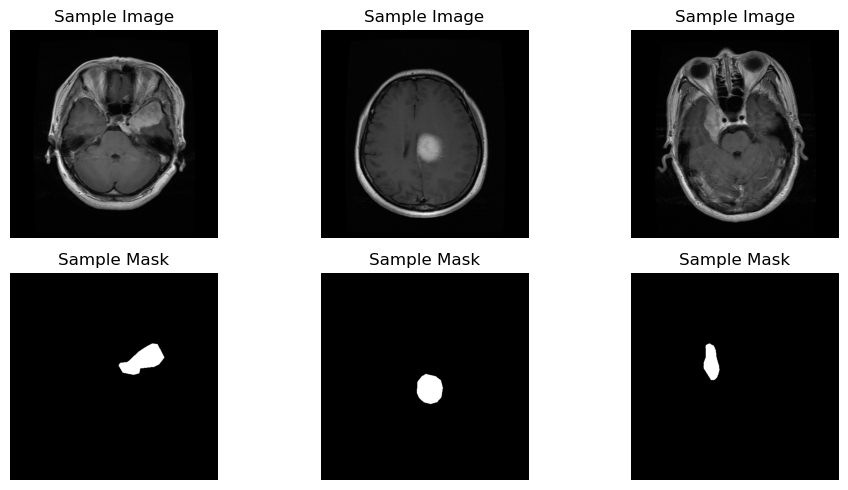

In [34]:
import matplotlib.pyplot as plt

# Display a few sample images and masks
plt.figure(figsize=(10, 5))
for i in range(3):
    img = cv2.imread(images[i])
    mask = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title("Sample Image")
    plt.axis('off')

    plt.subplot(2, 3, i+4)
    plt.imshow(mask, cmap='gray')
    plt.title("Sample Mask")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [35]:
# Model building
model = build_unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])
model.summary()



Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                              

                                                                                                  
 batch_normalization_44 (BatchN  (None, 16, 16, 1024  4096       ['conv2d_46[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_44 (Activation)     (None, 16, 16, 1024  0           ['batch_normalization_44[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 16, 16, 1024  9438208     ['activation_44[0][0]']          
                                )                                                                 
                                                                                                  
 batch_nor

 concatenate_11 (Concatenate)   (None, 256, 256, 12  0           ['conv2d_transpose_11[0][0]',    
                                8)                                'activation_37[0][0]']          
                                                                                                  
 conv2d_54 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_11[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_52 (BatchN  (None, 256, 256, 64  256        ['conv2d_54[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_52 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_52[0][0]'] 
          

In [36]:
# Model training
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)


Epoch 1/25
115/115 [==============================] - ETA: 0s - loss: 0.8731 - dice_coef: 0.1269 
Epoch 1: val_loss improved from inf to 0.96109, saving model to files\model.h5
115/115 [==============================] - 2315s 20s/step - loss: 0.8731 - dice_coef: 0.1269 - val_loss: 0.9611 - val_dice_coef: 0.0388 - lr: 1.0000e-04
Epoch 2/25
115/115 [==============================] - ETA: 0s - loss: 0.7677 - dice_coef: 0.2323 
Epoch 2: val_loss did not improve from 0.96109
115/115 [==============================] - 2295s 20s/step - loss: 0.7677 - dice_coef: 0.2323 - val_loss: 0.9868 - val_dice_coef: 0.0131 - lr: 1.0000e-04
Epoch 3/25
115/115 [==============================] - ETA: 0s - loss: 0.7026 - dice_coef: 0.2974 
Epoch 3: val_loss improved from 0.96109 to 0.93997, saving model to files\model.h5
115/115 [==============================] - 2320s 20s/step - loss: 0.7026 - dice_coef: 0.2974 - val_loss: 0.9400 - val_dice_coef: 0.0601 - lr: 1.0000e-04
Epoch 4/25
115/115 [==================

In [37]:
from tensorflow.keras.utils import CustomObjectScope

""" Load the model """
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("files", "model.h5"))


In [38]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("results")

""" Load the model """
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

""" Dataset """
dataset_path = "" 
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

""" Prediction and Evaluation """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    name = x.split("/")[-1]
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (W, H))
    x = image/255.0
    x = np.expand_dims(x, axis=0)

    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")


100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [04:00<00:00,  2.55it/s]

F1: 0.72958
Jaccard: 0.64265
Recall: 0.74203
Precision: 0.77568


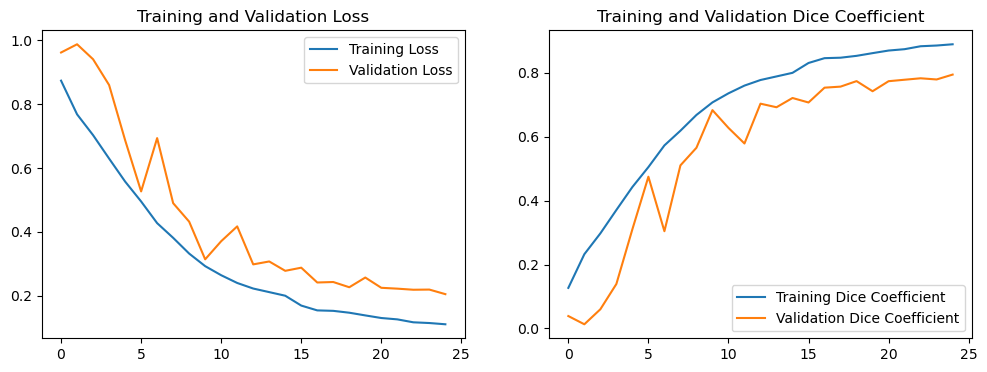

In [40]:
# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.legend()
plt.title('Training and Validation Dice Coefficient')
plt.show()

               F1     Jaccard      Recall   Precision
count  612.000000  612.000000  612.000000  612.000000
mean     0.729580    0.642647    0.742032    0.775681
std      0.299861    0.294655    0.317136    0.307638
min      0.000000    0.000000    0.000000    0.000000
25%      0.678897    0.513887    0.631806    0.748046
50%      0.861998    0.757466    0.890961    0.912875
75%      0.925860    0.861954    0.962398    0.977925
max      0.986163    0.972703    1.000000    1.000000


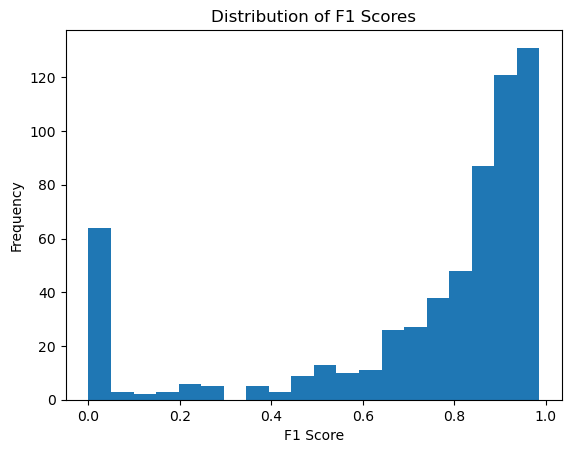

In [41]:
df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
print(df.describe())

# Plotting histogram of F1 scores
plt.hist(df['F1'], bins=20)
plt.title('Distribution of F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.show()

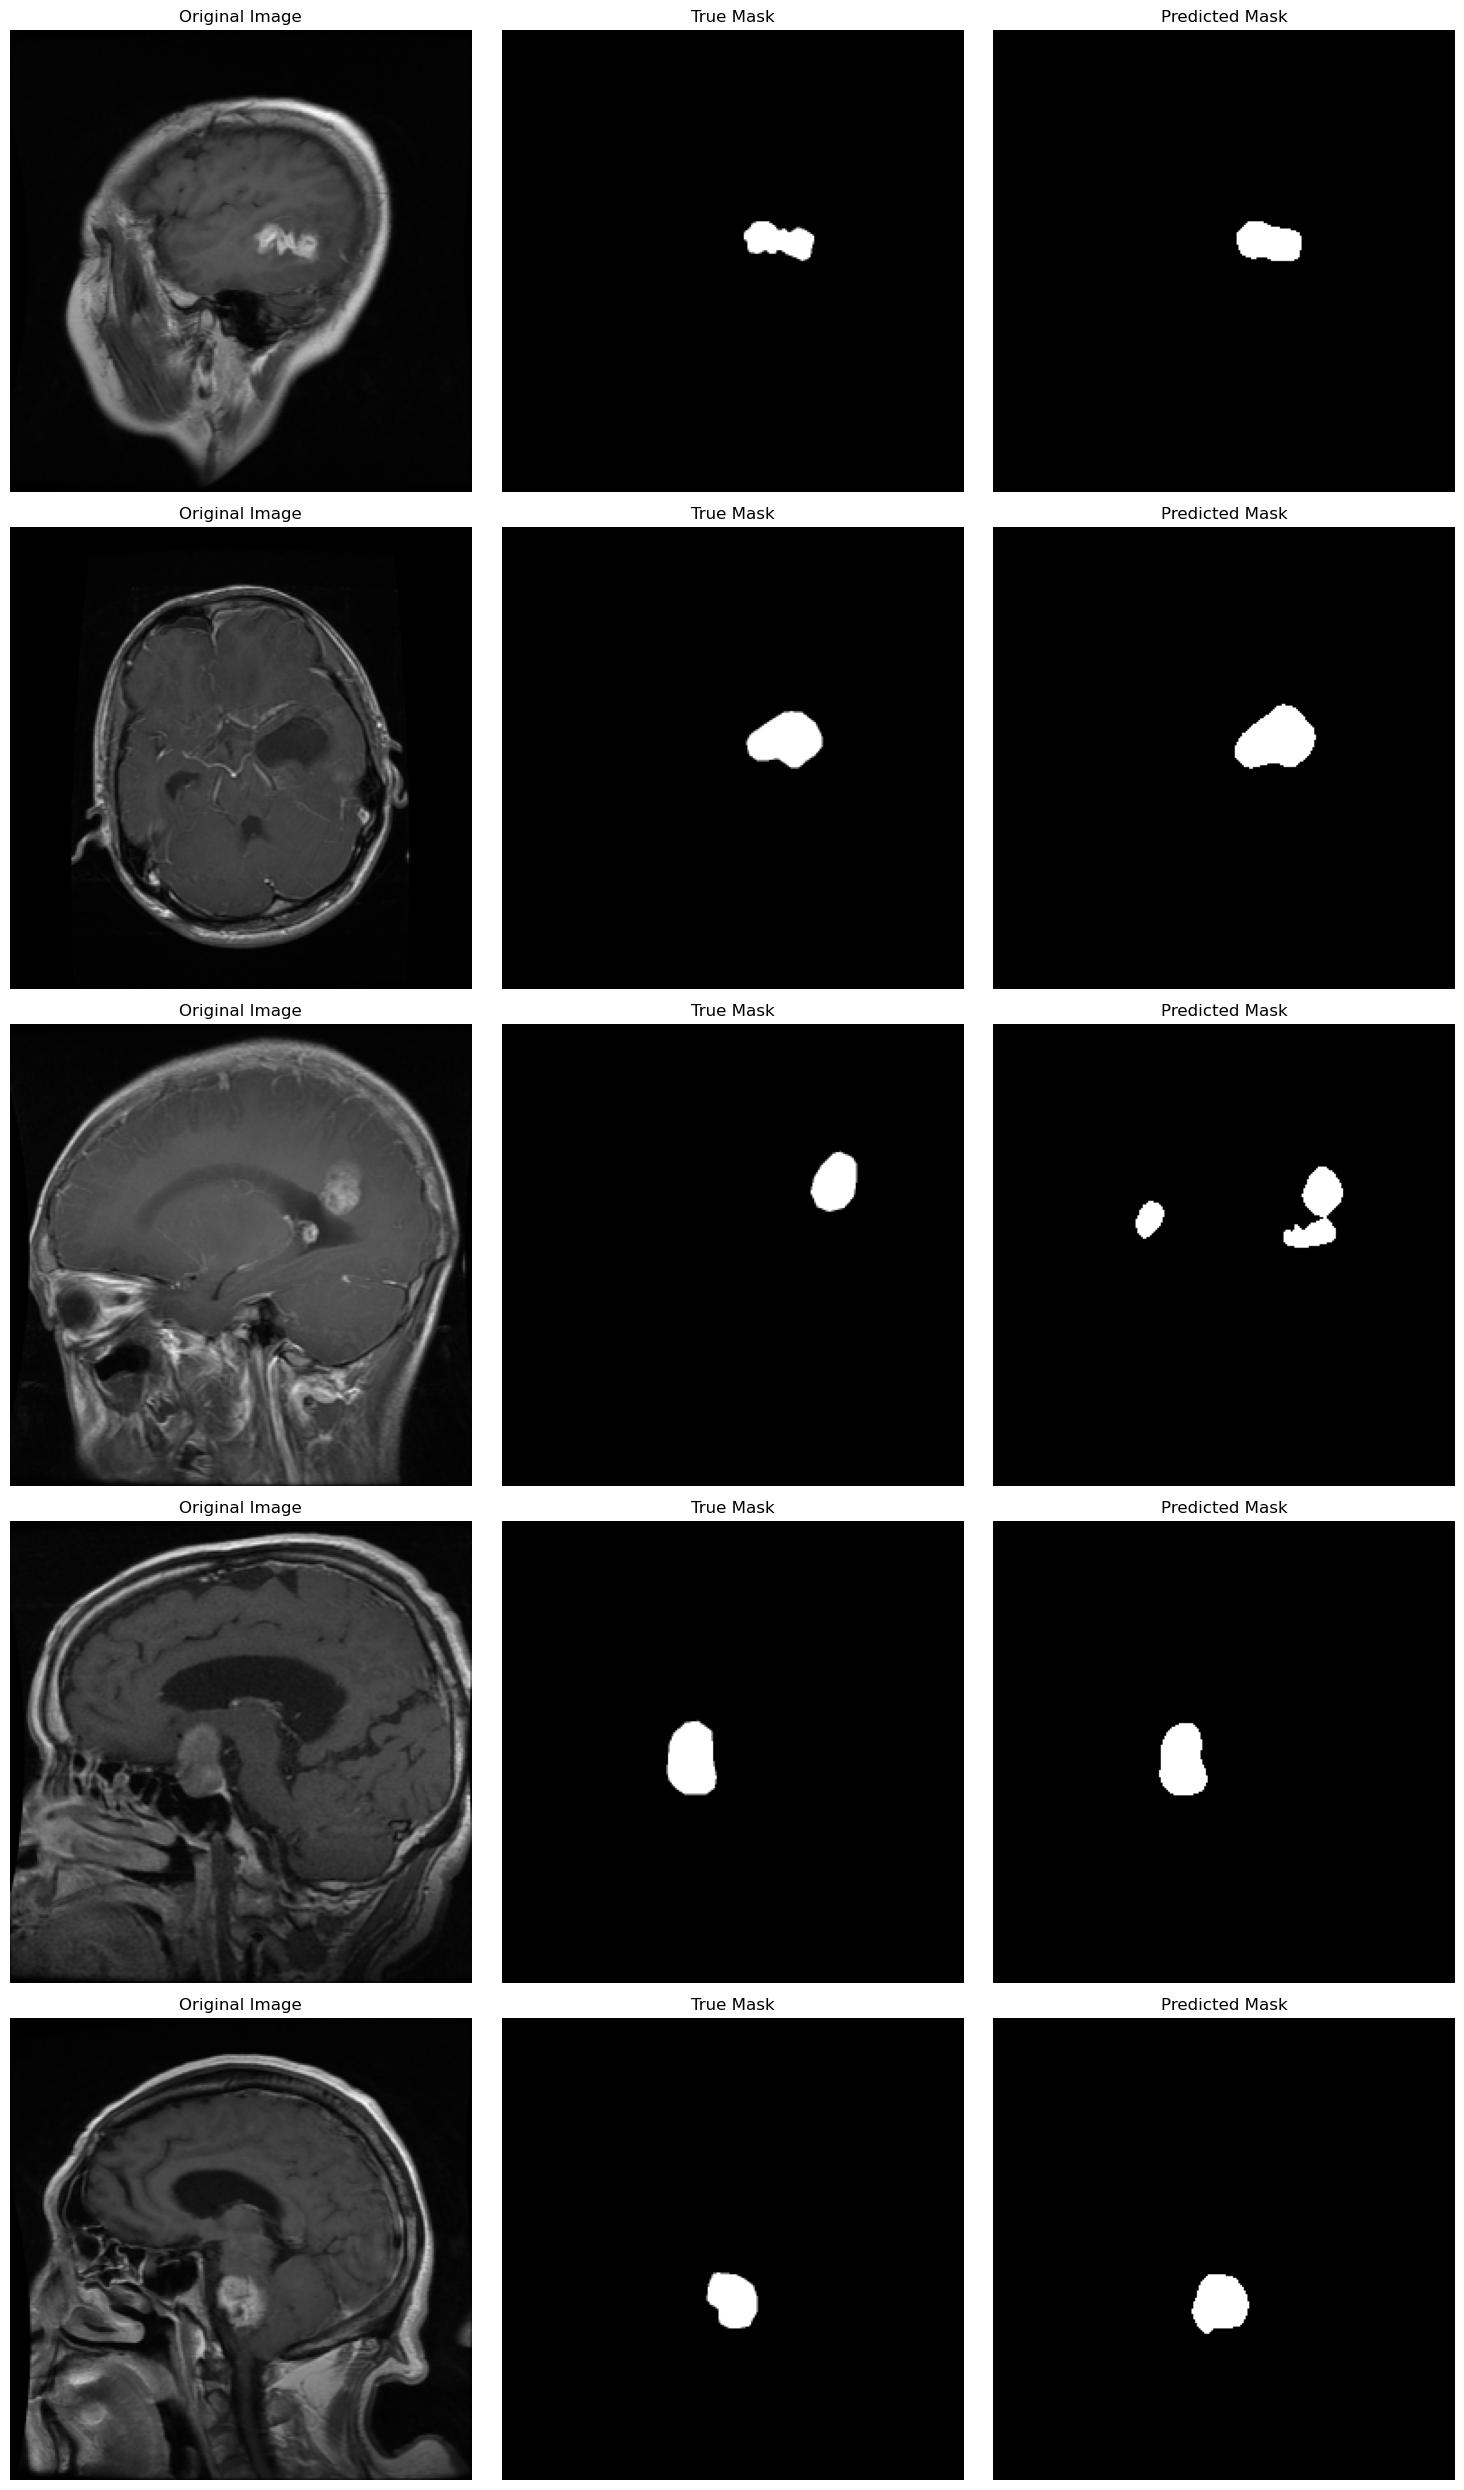

In [45]:
import matplotlib.pyplot as plt

num_samples_to_display = 5
samples_displayed = 0

plt.figure(figsize=(15, 5 * num_samples_to_display))

for i, (x, y) in enumerate(zip(test_x, test_y)):
    name = x.split("/")[-1]
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (W, H))
    original_image = image.copy()
    x = image / 255.0
    x = np.expand_dims(x, axis=0)

    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    if samples_displayed < num_samples_to_display:
        plt.subplot(num_samples_to_display, 3, samples_displayed * 3 + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples_to_display, 3, samples_displayed * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_samples_to_display, 3, samples_displayed * 3 + 3)
        plt.imshow(y_pred, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        samples_displayed += 1

    if samples_displayed >= num_samples_to_display:
        break

plt.tight_layout()
plt.show()